# 语义分割和数据集

最重要的语义分割数据集之一是[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
#                            '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
voc_dir = '../data/VOCdevkit/VOC2012'

将所有输入的图像和标签读入内存

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    # 1. 定位索引文件
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    #2. 设置图像读取模式
    mode = torchvision.io.image.ImageReadMode.RGB # 明确指定读取PNG标注图时使用RGB格式（尽管标注图是单通道索引图）
    # 3. 读取文件名列表
    with open(txt_fname, 'r') as f:
        images = f.read().split() # 按空白字符分割成列表
    # 4. 循环加载图像和标注
    features, labels = [], []
    for i, fname in enumerate(images):
        '''
        读取原始JPEG图像（特征）
        os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg') :构造完整路径
        JPEGImages：VOC数据集存放原始训练图像的文件夹
        torchvision.io.read_image(...):功能 ：读取图像文件并自动转换为张量；输出形状：(3,H,W)，三通道RGB图像
        features.append(...):将每张图像张量追加到列表，最终形成图像列表
        '''
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        '''
        读取PNG标注图（标签）（像素值=类别ID）
        SegmentationClass：存放像素级标注的文件夹
        f'{fname}.png' ：标注图与图像同名，但格式为PNG
        mode参数 ：强制以RGB模式读取（虽然标注图是单通道）
        '''
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    # 返回两个列表，每个元素是一个3D张量；训练集大小：1464张图像和对应标注
    return features, labels
'''
features: 存储RGB图像，形状 (3, H, W)
labels: 存储标注图，形状 (3, H, W)，但三个通道值相同（每个像素是类别索引0-20）

'''
train_features, train_labels = read_voc_images(voc_dir, True)

绘制前5个输入图像及其标签

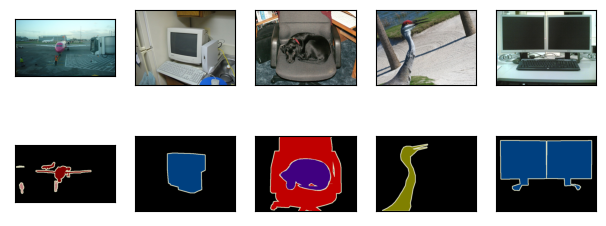

In [4]:
# 1. 设置显示数量:指定要显示的图像-标签对数量
n = 5
'''
2. 合并图像和标签
train_features[0:n]：前5张原始图像（列表，每个元素是 (3, H, W) 张量）
train_labels[0:n]：前5张标注图像（列表，每个元素是 (3, H, W) 张量）
+：列表拼接，结果为10个元素： [img1, img2, ..., img5, label1, label2, ..., label5]
'''
imgs = train_features[0:n] + train_labels[0:n]
'''
3. 调整维度顺序
转换前：(C, H, W) —— PyTorch默认格式，不适合matplotlib显示
转换后：(H, W, C) —— HWC格式，适配 imshow 的输入要求
列表推导式：对10张图像批量转换
新维度0←原维度1（高度H）
新维度1←原维度2（宽度W）
新维度2←原维度0（通道C）
'''
imgs = [img.permute(1,2,0) for img in imgs]
# 2：行数（原图和标签分两行显示）；n：列数（每行5张）
d2l.show_images(imgs, 2, n);

列举RGB颜色值和类名

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

查找标签中每个像素的类索引

In [6]:
'''
1. 构建颜色映射表
VOC标注图是RGB彩色图，需要将其映射为0-20的类别索引。
'''
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    # 创建一个巨大的查找表，覆盖所有可能的24位RGB值
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long) # # 大小16777216 (256³)
    # 填充映射关系
    for i, colormap in enumerate(VOC_COLORMAP):
        '''
        VOC_COLORMAP = [[0,0,0], [128,0,0], ...]共21个颜色
        编码公式（将RGB转为唯一整数ID）：index = ((R × 256) + G) × 256 + B
        每个RGB三元组对应唯一索引位置,在该位置存入类别ID i（如红色飞机→索引1）
        '''
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label
'''
2. 转换标注图为索引张量
colormap：标注图张量，形状(3, H, W)（RGB三通道）
colormap2label：上面生成的查找表
'''
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    # 步骤1：调整维度并转numpy
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32') # 从(3, H, W) → (H, W, 3)，便于逐像素处理
    '''
    步骤2：编码每个像素的RGB值
    得到形状 (H, W) 的整数索引矩阵
    '''
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    # 步骤3：查表获取类别索引
    # 输出形状：(H, W)，每个像素值是0-20的类别索引
    return colormap2label[idx]

例如

In [7]:
'''
转换标签为索引矩阵
train_labels[0] ：取出第一张训练图片的标注图，形状 (3, H, W)（RGB三通道）
voc_colormap2label() ：生成颜色查找表（将RGB三元组映射到类别索引0-20）
voc_label_indices(...) ： 逐像素转换每个RGB值为对应的类别索引
输出y
形状：(H, W) —— 二维整数矩阵
值范围：0（背景）到 20（20个目标类别+背景）
示例：y[200, 300] = 1 表示图像(200,300)位置是类别1
'''
y = voc_label_indices(train_labels[0], voc_colormap2label())
'''
查看局部区域+类别名称
y[105:115, 130:140] ：切片提取一个10×10像素的小区域
行范围：105到114（共10行）
列范围：130到139（共10列）
输出：10×10的整数子矩阵，显示该区域的类别分布
VOC_CLASSES[1]：查询索引1对应的类别名称
VOC_CLASSES是列表：['background', 'aeroplane', 'bicycle', ...]
VOC_CLASSES[1] → 'aeroplane' 
'''
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域

为什么必须同步？<br>
语义分割的本质：每个像素都有标签。如果图像和标签各自随机裁剪不同区域，会导致像素-标签错位，模型学到错误映射。
对比目标检测：
- 检测：对图像随机裁剪，只需相应调整框坐标
- 分割：对图像裁剪的同时，标签必须裁剪完全相同区域

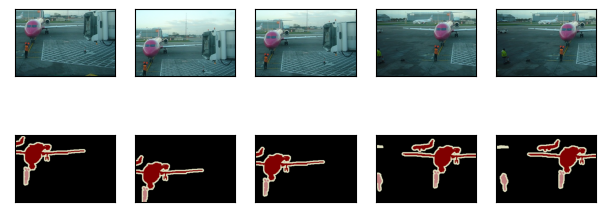

In [8]:
'''
原图: [███████████████████]
        ↑50 ↕200
        ┌───────┐
        │裁剪区域│ ← 同时作用于图像和标签
        └───────┘
        ←100 →300
'''
# 1. 同步裁剪
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    '''
    feature：原图（提供尺寸边界）;(height, width)：目标裁剪尺寸（如 200, 300）
    返回：rect = (top, left, height, width) —— 裁剪框的左上角坐标+尺寸
    '''
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    # 对特征图（原图）进行裁剪
    # rect：解包元组，等价于(top,left,height,width);结果：从原图中裁剪出指定区域，形状变为(C,200,300)
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 对标签图（语义标注）进行相同裁剪
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = [] # 初始化为空列表
'''
2. 批量生成裁剪样本
imgs += ... ：将返回的(feature,label)元组 拆开后追加到列表
第一次循环：imgs变为 [feature1,label1]
第二次循环：imgs变为 [feature1,label1,feature2,label2]
最终：imgs长度为2n，奇偶交替存储图像和标签
'''
for _ in range(n): # 循环n次：每次随机裁剪一次
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
# 3. 维度转换适配显示:将所有图像从(C, H, W)转为(H, W, C)
imgs = [img.permute(1, 2, 0) for img in imgs]
'''
4. 重排序后显示
imgs[::2]：提取所有偶数索引→[feature1,feature2,...,feature_n]
imgs[1::2]：提取所有奇数索引→[label1,label2,...,label_n]
+拼接 ：结果是 [所有特征图, 所有标签图]
show_images(..., 2, n) ：以 2行n列显示
第1行：n张随机裁剪的 原始图像;第2行：对应n张像素标签（伪彩色）
'''
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

自定义语义分割数据集类

In [9]:
'''
训练循环
    ↓
DataLoader调用__getitem__(idx)
    ↓
从内存列表取出图像和标签
    ↓
同步随机裁剪（图像+标签同一位置）
    ↓
RGB标签→类别索引转换
    ↓
返回(特征, 标签)元组

原始数据
  ├─ feature: (3, 512, 512) 归一化图像
  └─ label:   (3, 512, 512) RGB标签图
       ↓ voc_rand_crop
裁剪后
  ├─ feature: (3, 320, 480) 图像张量
  └─ label:   (3, 320, 480) RGB标签图
       ↓ voc_label_indices
最终标签: (320, 480) 类别索引矩阵（每个像素是0-20）
'''
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""
    
    def __init__(self, is_train, crop_size, voc_dir):
        # ImageNet统计的标准归一化参数
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 均值和标准差
        self.crop_size = crop_size # 裁剪尺寸(height, width)
        # 读取所有图像和标签（列表形式，已加载到内存）
        # features：每个元素是 (3, H, W) 的RGB图像张量;labels：每个元素是 (3, H, W) 的RGB标注图张量
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        # 过滤+归一化特征图，只过滤标签
        # 过滤掉尺寸小于crop_size的图像，避免裁剪时越界
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        # 构建颜色到类别的查找表
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
    # 归一化方法
    def normalize_image(self, img):
        # 计算机中，彩色图像的每个通道（R/G/B）通常用8位无符号整数（uint8）存储
        return self.transform(img.float() / 255)
    # 过滤方法
    def filter(self, imgs):
        '''
        在PyTorch中，img是(C,H,W)格式的张量：
        shape[0]：通道数（Channels）;shape[1]：高度（Height）;shape[2]：宽度（Width）
        '''
        return [img for img in imgs if (
            # voc_rand_crop要求原图尺寸≥裁剪尺寸
            img.shape[1] >= self.crop_size[0] and # 图像高度必须 ≥ 裁剪高度
            img.shape[2] >= self.crop_size[1])] # 图像宽度必须 ≥ 裁剪宽度
    # 索引访问
    def __getitem__(self, idx):
        '''
        在线随机裁剪（每次访问都不同，数据增强）
        self.features[idx]：第idx张归一化后的图像，形状 (3, H, W)
        self.labels[idx]：对应的 RGB标签图，形状 (3, H, W)
        *self.crop_size： 解包元组 (crop_h, crop_w) 为两个独立参数
        voc_rand_crop：对 图像和标签同步裁剪，返回：
            feature：裁剪后的图像，形状 (3, crop_h, crop_w)
            label：裁剪后的RGB标签，形状 (3, crop_h, crop_w)
        '''
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        '''
        voc_label_indices(label, self.colormap2label) ： 将RGB标签图转换为类别索引矩阵
        输入：label（RGB三通道张量）
        处理：利用 colormap2label 查找表，将每个像素的RGB值映射为0-20的整数类别ID
        输出：形状 (crop_h, crop_w)，每个元素是类别索引
        返回元组：(feature, label_indices)
        feature：模型输入图像，形状 (3, crop_h, crop_w)
        label_indices：训练目标，形状 (crop_h, crop_w)
        '''
        return (feature, voc_label_indices(label, self.colormap2label))
    # 数据集大小
    def __len__(self):
        return len(self.features)

读取数据集

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [13]:
import time
start = time.time()
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, # 自定义的VOCSegDataset实例
                                         batch_size, # 每批64个样本
                                         shuffle=True, # 每个epoch打乱数据顺序（防止过拟合）
                                         # 确保每个batch形状固定，便于GPU并行计算
                                         drop_last=True, # 丢弃不足64个的最后一个批次，
                                         # num_workers=d2l.get_dataloader_workers()
                                         num_workers=0) # 单进程加载（避免Jupyter多进程卡死）

first_batch_time = time.time() - start  # 通常<1秒

start = time.time()
for X, Y in train_iter:
    print(f"加载时间: {time.time() - start:.2f}秒")
    print(X.shape) # 打印图像批次形状
    print(Y.shape) # 打印标签批次形状
    break # 只取第一个批次后退出

加载时间: 0.20秒
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


整合所有组件

In [12]:
'''
batch_size：每个批次的样本数量
crop_size：输入模型的图像/标签尺寸元组 (height, width)
'''
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    '''
    2. 数据集下载与解压
    自动下载：从D2L服务器下载VOC2012数据集（首次运行时）
    缓存机制：若本地已存在，直接返回路径，无需重复下载
    返回路径：解压后的数据集根目录
    '''
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    '''
    3. 自动获取最优线程数
    动态适配：根据当前CPU核心数返回合适的工作进程数
    Linux：通常返回4-8
    Windows/Jupyter：建议手动设为0避免多进程卡死
    '''
    num_workers = d2l.get_dataloader_workers()
    '''
    4. 创建训练集DataLoader
    VOCSegDataset(True, ...)：训练模式，会读取train.txt
    shuffle=True：确保每个epoch数据顺序不同，防止过拟合
    drop_last=True：保证每个batch形状固定，利于GPU加速
    '''
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size, # True=训练集
        shuffle=True, # 打乱数据（训练必需）
        drop_last=True, # 丢弃不足batch的剩余样本
        num_workers=num_workers)
    '''
    5. 创建测试集DataLoader
    VOCSegDataset(False, ...)：验证模式，读取val.txt
    无shuffle：保持原始顺序，便于评估模型性能
    无数据增强：验证时不需要随机裁剪（实际会固定中心裁剪或全图）
    '''
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size, # False=验证集
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter